In [1]:
import sys
sys.path.insert(0, '../')
sys.path.append('/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages') # se non carica gymnasium mettere path modulo


import gymnasium as gym
print(f"Gym Version = {gym.__version__}")

import AddictiveReward

import numpy as np
import numba as nb
from numba.experimental import jitclass

from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium import spaces
import random
from numpy.random import choice
#from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from typing import Optional

Gym Version = 0.29.1


In [2]:
env = gym.make('AddictiveEnv_v3')

### Data Plot

In [3]:
def data_plot():
    timestamps_arm, reward_b, reward_a = env.unwrapped.get_statistics() 
    time_values = np.arange(len(timestamps_arm))
    time_values_arm = np.arange(len(reward_b))
    time_values_arm2 = np.arange(len(reward_a))
    print(sum(timestamps_arm))
    
    plt.figure(figsize=(16, 12))
    plt.subplot(2, 2, 1)
    plt.plot(addicted_rates, label='cumsum addicted')
    plt.title('Addicted Rates')
    plt.xlabel('Episode')
    plt.ylabel('Addiction Transition')
    plt.legend()
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    

    plt.subplot(2, 2, 3)
    plt.plot(healthy_rates, label='cumsum healthy')
    plt.title('Healty Rates')
    plt.xlabel('Episode')
    plt.ylabel('Healty Transition')
    plt.legend()
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    # Plot for total_reward
    plt.subplot(2, 2, 4)
    plt.plot(total_reward, label='Total Reward')
    plt.title('Total Reward (testing)')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.legend()
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    plt.subplot(2, 2, 2)
    plt.scatter(time_values, timestamps_arm, marker='o', linestyle='-')
    plt.title('T Addicted Arm 0 = addictive, 1 = !addictive')
    plt.xlabel('Episode')
    plt.ylabel('Total addicted arm')
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)

    plt.figure(figsize=(16, 12))
    plt.subplot(2, 2, 1)
    plt.scatter(time_values_arm, reward_b, marker='o', linestyle='-')
    plt.title('T Addicted Arm 0 = addictive, 1 = !addictive')
    plt.xlabel('Episode')
    plt.ylabel('Total addicted arm')
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)

    plt.subplot(2, 2, 2)
    plt.scatter(time_values_arm2, reward_a, marker='o', linestyle='-')
    plt.title('T Addicted Arm 0 = addictive, 1 = !addictive')
    plt.xlabel('Episode')
    plt.ylabel('Total addicted arm')
    plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

## AGENTE MF

In [3]:
class MFLearningAgent:
    def __init__(self, 
                 learning_rate: float,  
                 initial_epsilon: float, 
                 epsilon_decay: float,  
                 final_epsilon: float, 
                 discount_factor: float = 0.9):
        
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.training_error = []

    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values
    
    # def update_value_iteration(self, state, action, reward, next_state):
    #     old_value = self.q_values[state, action] 
    #     next_max = np.max(self.value_iteration[next_state, :])
    #     self.q_values[state, action] =  (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max) 

    def update(self, obs: int, action: int, reward: float, terminated: bool, next_obs: int):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

        
    def decay_epsilon(self):
       self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

### Test MF

In [5]:
lr = 0.01

n_episodes = 1

start_epsilon = 0.4
epsilon_decay = start_epsilon / (env.unwrapped.get_iter() / 2)  # reduce the exploration over time
final_epsilon = 0.1

agentMF = MFLearningAgent(
    learning_rate = lr,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
)


In [6]:
# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
addiction_states = []
total_reward = []
healty_states = []

healthy_rates = []
addicted_rates = []



pbar = tqdm(total = env.get_iter()+1)

obs, info = env.reset()
done = False
addicted = 0
healthy = 0
r = 0

healty_arm = 0
addicted_arm = 0

step = 1
# play one episode

a_count = 1
h_count = 1
action_ad = 1

while not done:
    action = agentMF.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

  
    # update the agent
    agentMF.update(obs, action, reward, terminated, next_obs)
    
    if obs == 3 and action == 4:
        action_ad += 1
        
    if obs == 3 and next_obs == 4:
        a_count += 1 
    elif obs == 2 and next_obs == 1:
        h_count += 1
        
    done = terminated or truncated
    obs = next_obs
    r += reward
    

    total_reward.append(r)

    
    addicted_rates.append(a_count)
    healthy_rates.append(h_count )


    
    step += 1
    pbar.update(1)
pbar.close()

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [00:00<00:00, 30498.94it/s]


In [7]:
print(f"addicted {a_count}")
print(f"healthy {h_count}")


addicted 505
healthy 173


1170


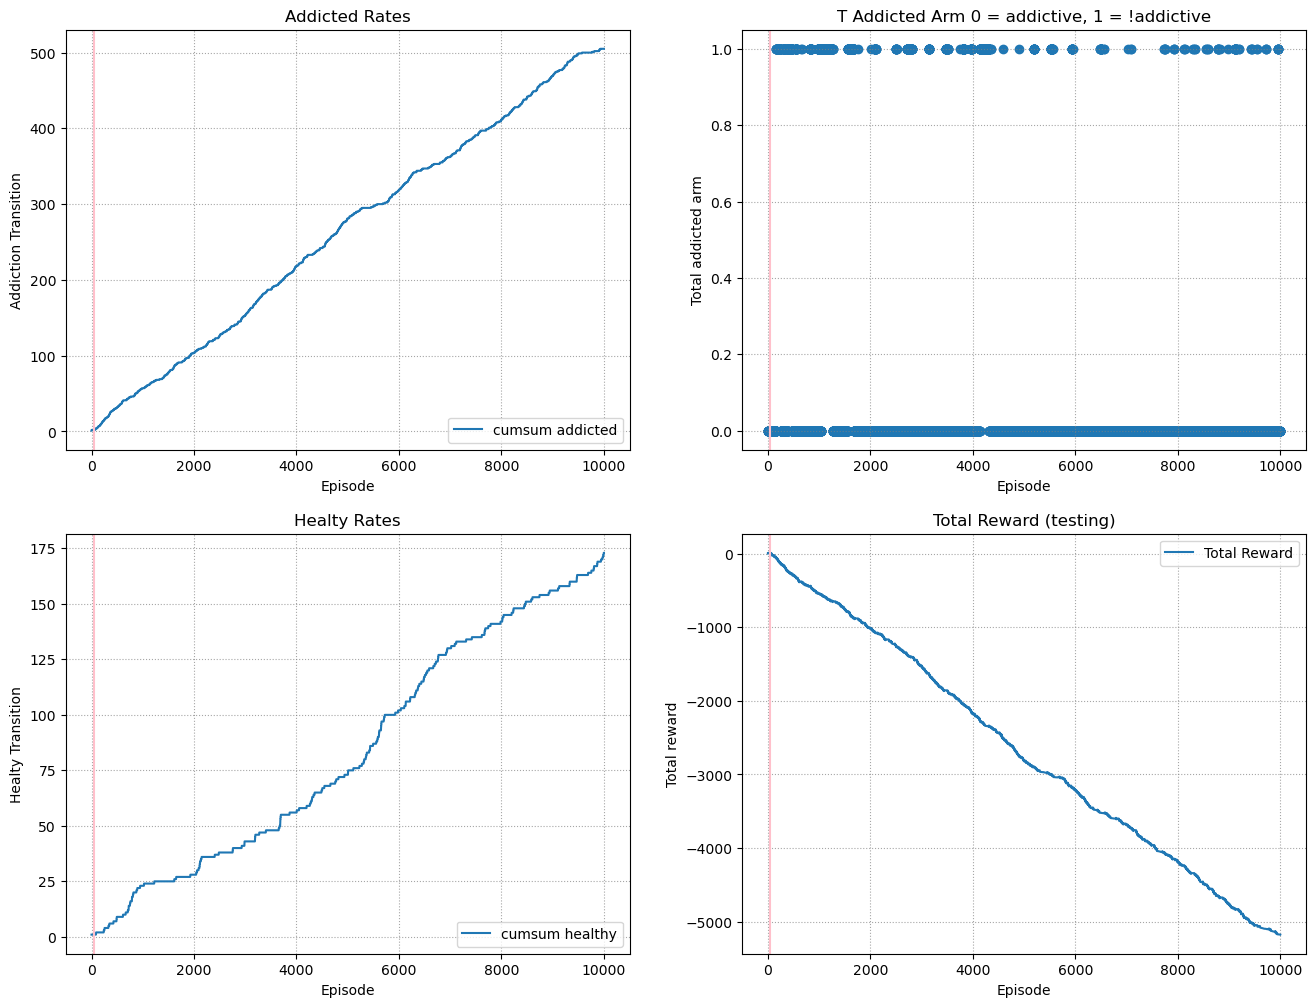

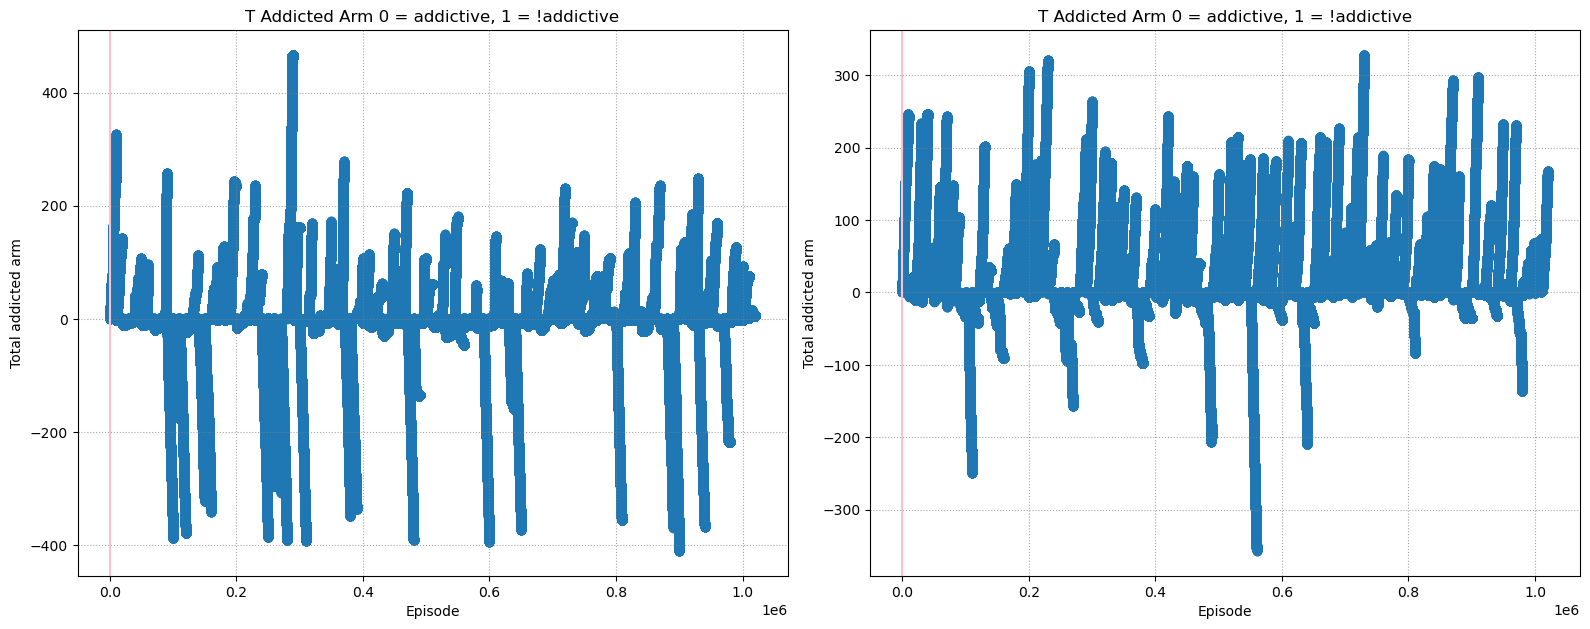

In [12]:
# print(addicted)
# print(healty)
data_plot()

## AGENTE MB

### Classes

In [15]:
import heapq
class PriorityQueue:
    def __init__(self):
        self._queue = []
        self._index = 0

    def is_empty(self):
        if self._queue  == []:
            return True
        return False
        
    def insert(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def clean(self):
        self._queue = []
        self.index = 0
        
    def pop(self):
        return heapq.heappop(self._queue)[-1]

#### GPU test ####

In [16]:
def transition_model_to_numpy(transition_model, obs_space, action_space):
    transition_array = np.zeros((obs_space, action_space, obs_space, 3))  # Assuming 3 fields: count, probability, reward
    
    for state in range(1, obs_space):
        for action in range(action_space):
            for next_state in range(1, obs_space):
                transition_info = transition_model[state][action].get(next_state, {'count': 0, 'probability': 0, 'reward': 0})
                transition_array[state, action, next_state] = [transition_info.get('count', 0), transition_info.get('probability', 0), transition_info.get('reward', 0)]

    #print(transition_array)
    return transition_array



@nb.jit
def value_iteration_gpu(iterations, obs_space, action_space, transition_model, discount_factor, q_values):
    epsilon = 0.1
    delta = 1.0  # Set an initial value for delta
    
    while iterations > 0 and delta > epsilon:
        delta = 0
        
        for state in range(1, obs_space):
            for action in range(action_space):
                t = 0
                for next_state in range(1, obs_space):
                    count, probability, reward = transition_model[state, action, next_state]
                    t += probability * (reward + discount_factor * np.max(q_values[next_state]))
                q_values[state, action] = t
            
                # Calculate delta
                Vs = abs(q_values[state, action] - np.max(q_values[state]))
                delta = max(delta, Vs)
        
        iterations -= 1  # Decrease the number of iterations
    
    return q_values

#### mb agent

In [17]:
class MBLearningAgent:
    def __init__(self, learning_rate: float, initial_epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.9, mbus = 50 ,theta=0.01):
        
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.mbus = mbus
        self.transition_model = {} 
        self.initialize_transition_model()
        
        self.training_error = []
        
        self.pred_queue = PriorityQueue()
        self.theta = theta 
        self.upd = 0
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values

    def value_iteration(self, iter):
        epsilon = 0.1
        for _ in range(1, iter):
            delta = 0
            for state in range(1, env.observation_space.n):
                for action in range(0,  env.action_space.n):
                    t = 0
                    for next_state in self.transition_model[state][action]:
                        probability = self.transition_model[state][action][next_state]['probability']
                        reward = self.transition_model[state][action][next_state]['reward']
                        t += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
                    self.q_values[state][action] = t
                     
                Vs = abs(self.q_values[state][action] - np.max(self.q_values[state]))
                delta = max(delta, Vs)
                
            if delta < epsilon and delta > 0:
                break

    def prioritized_sweeping(self, state, action):
        self.calculate_sweep(state, action)
        while not (self.pred_queue.is_empty()):
            if self.upd > self.mbus:
                #print("stopped")
                self.pred_queue.clean()
                break
            state = self.pred_queue.pop()
                        
            for state_p in range(1, env.observation_space.n):
                for action_p in range(env.action_space.n): 
                    for next_state_p in self.transition_model[state_p][action_p]:
                        if next_state_p == state:
                            self.calculate_sweep(state_p, action_p)
                            

    def calculate_sweep(self, state, action):
        old_q = self.q_values[state][action]
        new_q = 0
        
        for next_state in self.transition_model[state][action]:
            probability = self.transition_model[state][action][next_state]['probability']
            reward = self.transition_model[state][action][next_state]['reward']
            new_q += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
        self.q_values[state][action] = new_q
        p = abs(new_q - old_q)
        if p > 0:
            self.upd += 1
            max_q = np.max(self.q_values[state])
            if old_q == max_q or new_q == max_q:
                 self.pred_queue.insert(state, p)
       
    def initialize_transition_model(self):
        for state in range(1, env.observation_space.n):
            self.transition_model[state] = {}
            for action in range(env.action_space.n):
                self.transition_model[state][action] = {}
                for next_state in range(env.observation_space.n):
                    self.transition_model[state][action][next_state] = {'count': 0, 'probability': 0, 'reward': 0}
                    
    def update_transition_model(self, state, action, next_state, reward):
        self.transition_model[state][action][next_state]['count'] += 1
        self.transition_model[state][action][next_state]['reward'] = reward
        self.calculate_transition_probabilities()
        
        #self.prioritized_sweeping(obs, action)
        
        transition_array = transition_model_to_numpy(self.transition_model, env.observation_space.n, env.action_space.n)
        self.q_values = value_iteration_gpu(self.mbus, env.observation_space.n, env.action_space.n, transition_array, self.discount_factor, self.q_values)
        
        #self.value_iteration(self.mbus)
        
    def calculate_transition_probabilities(self):
        
        for state in range(1, env.observation_space.n):
            for action in range(env.action_space.n):
                total_count = sum(self.transition_model[state][action][next_state]['count'] for next_state in self.transition_model[state][action])
                for next_state in self.transition_model[state][action]:
                    
                    c = self.transition_model[state][action][next_state]['count']
                    if total_count == 0:
                        total_count = 1
                    self.transition_model[state][action][next_state]['probability'] = c / total_count
                    #if  self.transition_model[state][action][next_state]['probability'] != 0:
                    #    print(f"{state} {action} {next_state} { self.transition_model[state][action][next_state]['probability']}")
    
    def decay_epsilon(self):
       self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    

### Test MB

In [18]:
lr = 0.01
n_episodes = 1

start_epsilon = 0.4
epsilon_decay = start_epsilon / (env.get_iter() / 2)  # reduce the exploration over time
final_epsilon = 0.1

agentMB = MBLearningAgent(
    learning_rate = lr,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
    mbus = 10
)


In [19]:

addiction_states = []
total_reward = []
healty_states = []

healthy_rates = []
addicted_rates = []


In [20]:
pbar = tqdm(total = env.get_iter() + 1)

obs, info = env.reset()

done = False
addicted = 0
healthy = 0
r = 0

healty_arm = 0
addicted_arm = 0

a_count = 1
h_count = 1

step = 1
# play one episode
while not done:
    action = agentMB.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    agentMB.update_transition_model(obs, action, next_obs, reward)
            
    if obs == 3 and next_obs == 4:
        a_count += 1 
    elif obs == 2 and next_obs == 1:
        h_count += 1

    
    done = terminated or truncated
    obs = next_obs
    r += reward

    agentMB.decay_epsilon()

    total_reward.append(r)    
    addicted_rates.append(a_count)
    healthy_rates.append(h_count )
    
    pbar.update(1)

pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:01<00:00, 877.06it/s]


In [21]:
agentMB.transition_model[3][4]

{0: {'count': 0, 'probability': 0.0, 'reward': 0},
 1: {'count': 0, 'probability': 0.0, 'reward': 0},
 2: {'count': 1, 'probability': 1.0, 'reward': -0.5},
 3: {'count': 0, 'probability': 0.0, 'reward': 0},
 4: {'count': 0, 'probability': 0.0, 'reward': 0}}

0


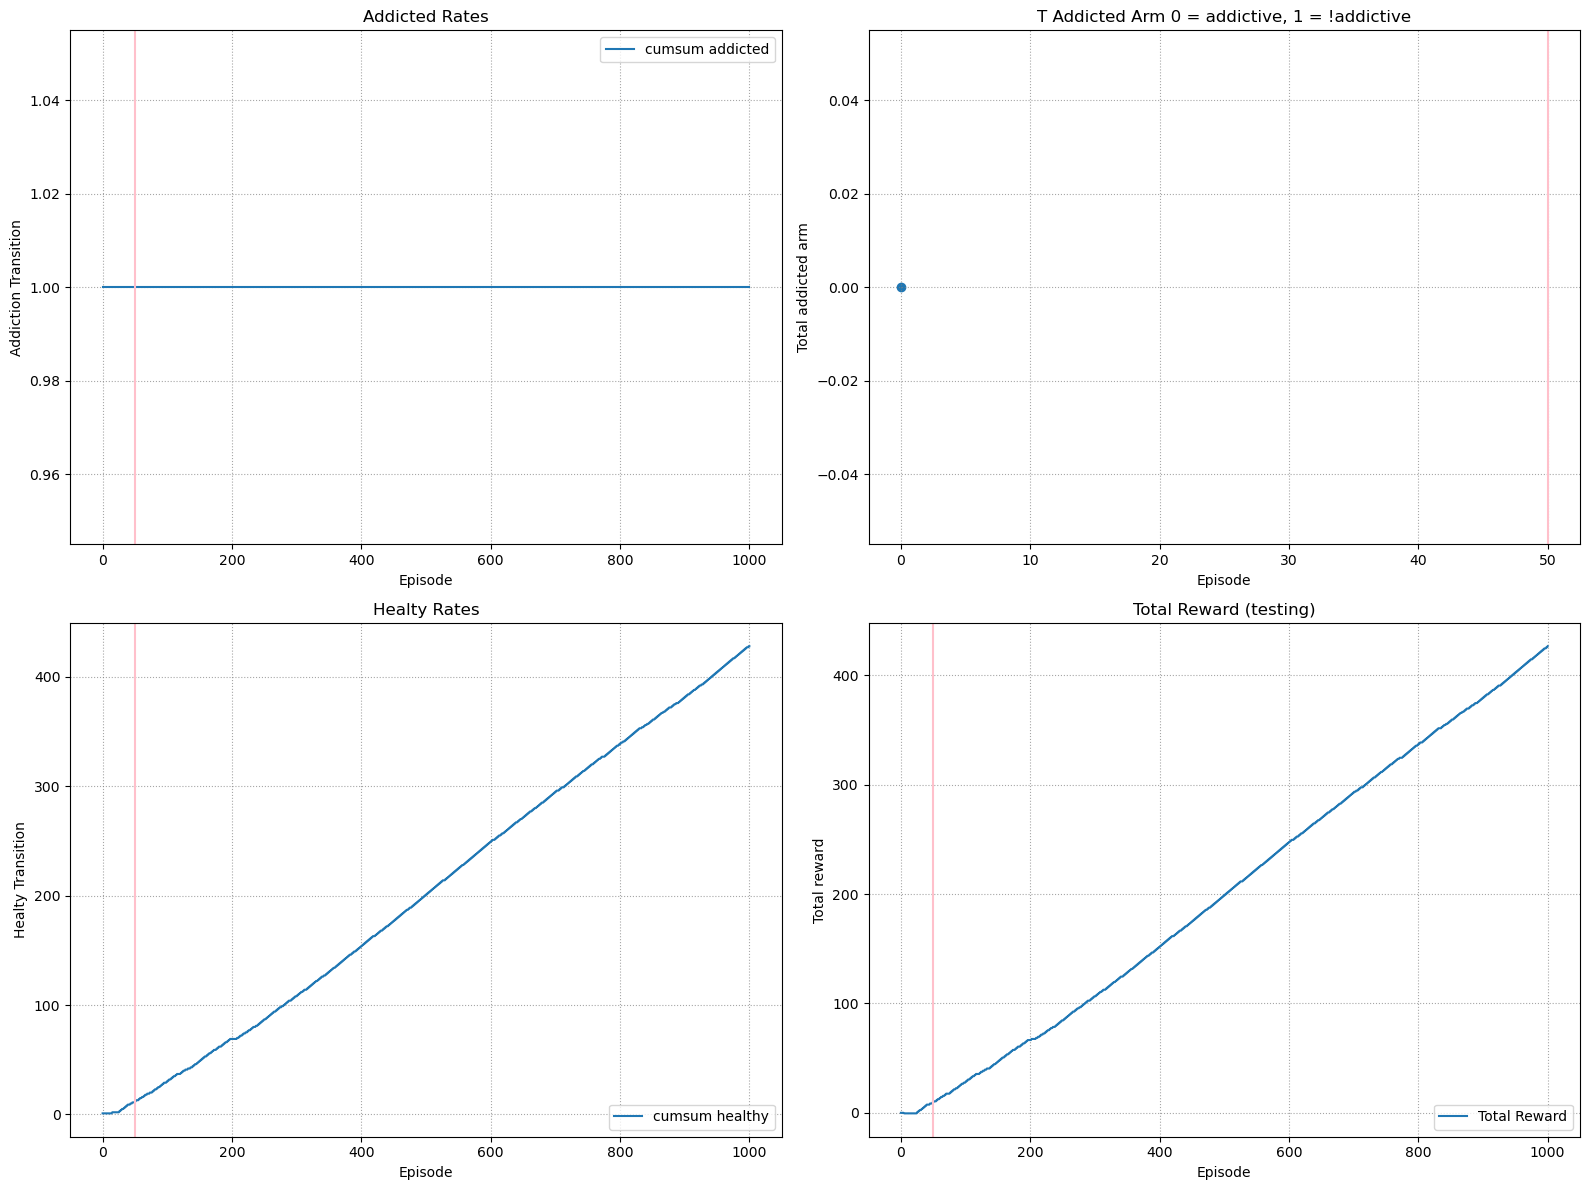

In [22]:
data_plot()

## MX Agent ##

In [23]:
class MXLearningAgent:
    def __init__(self, lr, ie, ed, fe, Beta, Epsilon, MBUS):
        self.MF_agent = MFLearningAgent(
                            learning_rate = lr,
                            initial_epsilon = ie,
                            epsilon_decay = ed,
                            final_epsilon = fe,
                        )
        self.MB_agent = MBLearningAgent(
                            learning_rate = lr,
                            initial_epsilon = ie,
                            epsilon_decay = ed,
                            final_epsilon = fe,
                            mbus = MBUS
                        )
        self.beta = Beta
        self.epsilon = Epsilon
    
    def get_action(self, state):
        if random.uniform(0, 1) > self.epsilon:
            if random.uniform(0, 1) < self.beta: # Beta 1 = MB || Beta = 0 = MF
                return np.argmax(self.MB_agent.q_values[state]) # Explore action space
            else:
                return np.argmax(self.MF_agent.q_values[state])  # Exploit learned values  
        else:
            return env.action_space.sample()
            
    def update(self, obs, action, reward, terminated, next_obs):
        self.MF_agent.update(obs, action, reward, terminated, next_obs)
        self.MF_agent.decay_epsilon()
        self.MB_agent.update_transition_model(obs, action, next_obs, reward)
        self.MB_agent.decay_epsilon()
        

### MX test ###

In [24]:
lr = 0.01
n_episodes = 1

ie = 0.4
ed = ie / (env.get_iter() / 2)  # reduce the exploration over time
fe = 0.1

beta = 0.5

agentMX = MXLearningAgent(
    lr = lr,
    ie = ie,
    ed = ed,
    fe = fe,
    Beta = beta,
    Epsilon = 0.1,
    MBUS = 50,
)



addiction_states = []
total_reward = []
healthy_rates = []

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(


In [25]:

pbar = tqdm(total = env.get_iter()+1)
#for episode in tqdm(range(n_episodes)):
obs, info = env.reset()
done = False
addicted = 0
r = 0

a_count = 1
h_count = 1

while not done:
    action = agentMX.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)
    agentMX.update(obs, action, reward, terminated, next_obs)
    
    if obs == 3 and next_obs == 4:
        a_count += 1 
    elif obs == 2 and next_obs == 1:
        h_count += 1


    done = terminated or truncated
    obs = next_obs
    r += reward
    
    healthy_rates.append(h_count / a_count)
    pbar.update(1)
    
    addiction_states.append(addicted)
    total_reward.append(r)
    
pbar.close()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 3256.99it/s]


In [26]:
agentMX.MF_agent.q_values
print(h_count)
print(a_count)

369
1


0


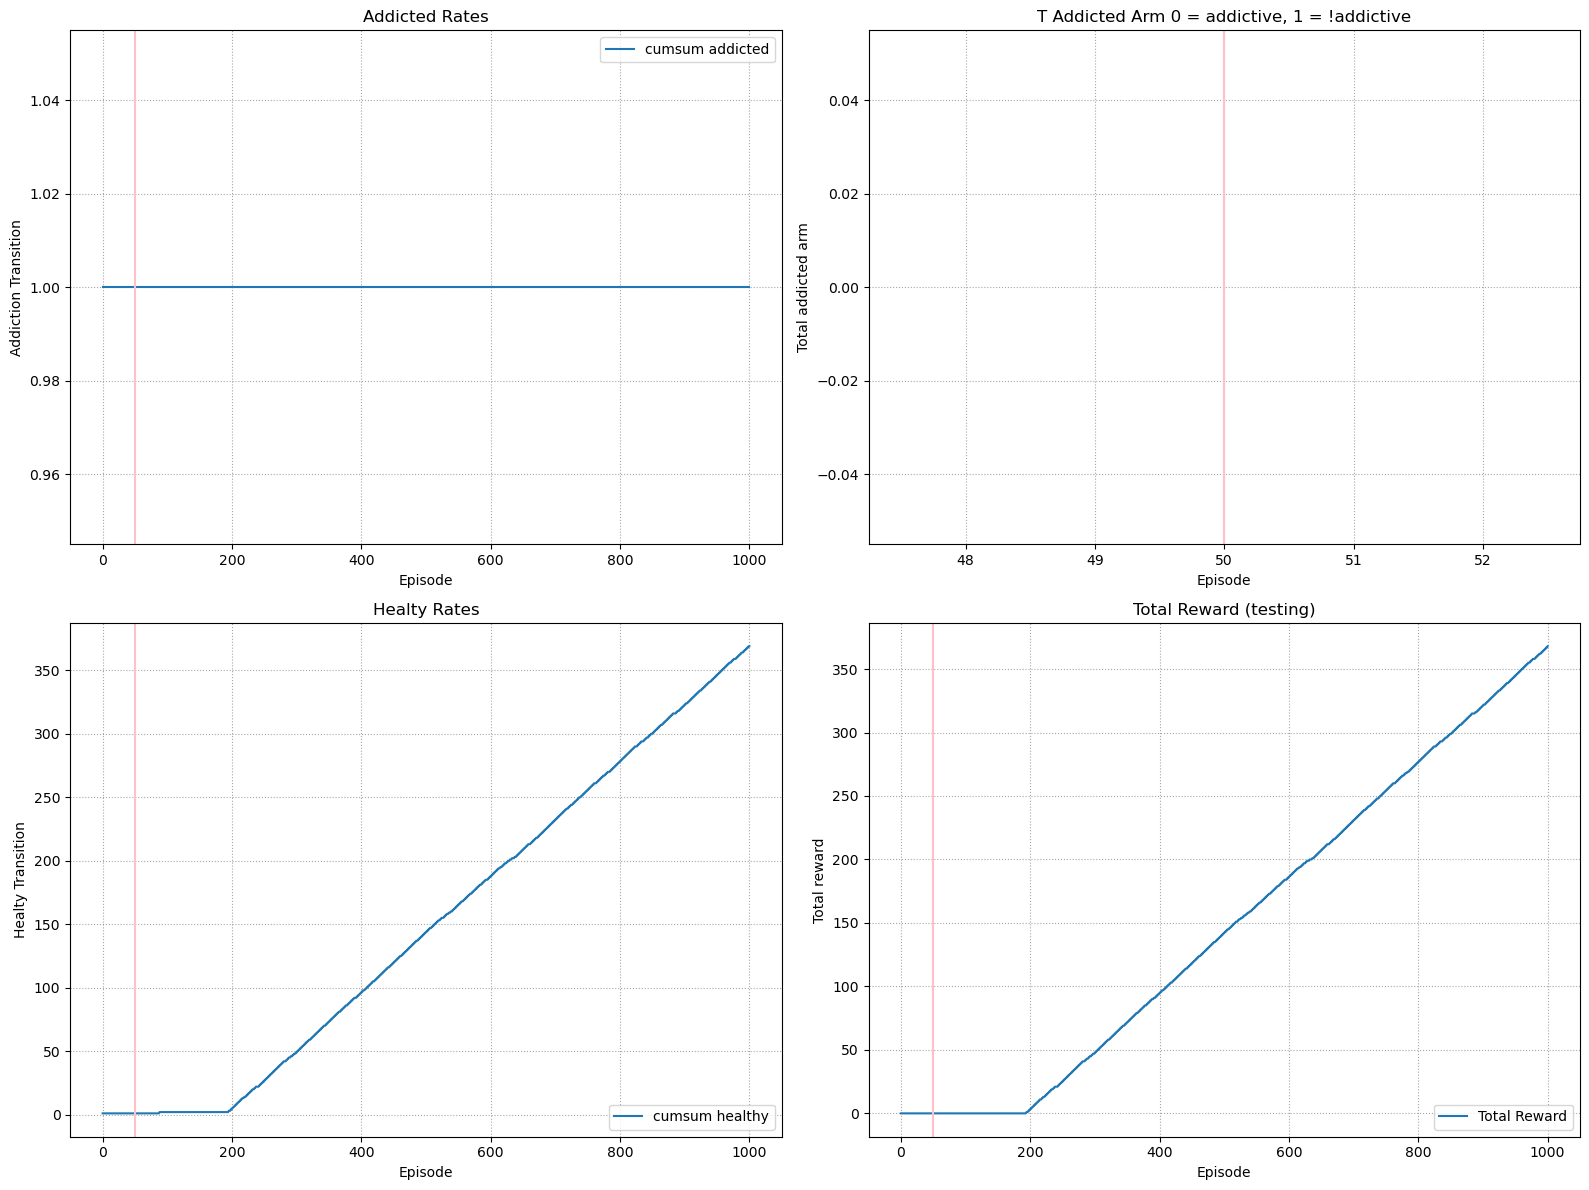

In [27]:
data_plot()

## Multi agent test ##

In [4]:
# agenti
agents = []
addiction_states = []

# parametri
lr = 0.01


nagenti = 20


pbar_a = tqdm_notebook(total = nagenti, desc='Agent Loop')
timestamps = env.get_iter()+2

ie = 0.4
ed = ie / (timestamps / 2)  # reduce the exploration over time
fe = 0.1

agents = []
for _ in range(nagenti):
    # agent = MXLearningAgent(
    #     lr = lr,
    #     ie = ie,
    #     ed = ed,
    #     fe = fe,
    #     Beta = beta,
    #     Epsilon = 0.1,
    #     MBUS = 1,
    # )
    agent = MFLearningAgent(
        learning_rate = lr,
        initial_epsilon = ie,
        epsilon_decay = ed,
        final_epsilon = fe,
    )
    agents.append(agent)

addicted_agents = 0

tot_addict = 0
tot_healthy = 0

recommender_rew_b = 0

mean_addictive_agent = np.zeros([nagenti, timestamps])
mean_arms_t = np.zeros([nagenti, timestamps])
# mean_rewardb_recom = np.zeros(timestamps)
# mean_rewarda_recom = np.zeros(timestamps)

n_a = 0
for agent in agents: 
   
    
    pbar_a.update(1) 
    obs, info = env.reset()
    
    done = False
    
    addicted_count = 0
    healthy_count = 0  
    ad_count = 0
    
    n_t = 0
    while not done:
        n_t += 1
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)
        
        #conto stati
        if(obs==3 and action == 4):
            ad_count += 1
        if(obs == 3 and next_obs == 4):
            addicted_count +=  1
        if(obs == 2 and next_obs == 1):
            healthy_count += 1
    
           
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

        # rewards_reco = env.get_rewards()
        # mean_rewardb_recom[n_t] += rewards_reco[1]
        # mean_rewarda_recom[n_t] += rewards_reco[0]
        
        if addicted_count > healthy_count:
            mean_addictive_agent[n_a][n_t] = 1
        else:
            mean_addictive_agent[n_a][n_t] = 0

    # arms = env.unwrapped.get_statistics() 
        mean_arms_t[n_a][n_t] = env.unwrapped.get_arms()     
    
    n_a += 1        
    if addicted_count > healthy_count:
        tot_addict += 1
        
tot_healthy = nagenti - tot_addict

# for i in range(timestamps):
#     mean_rewardb_recom[i] = mean_rewardb_recom[i] / nagenti 
#     mean_rewarda_recom[i] = mean_rewarda_recom[i] / nagenti 
    #mean_addictive_agent[i] = mean_addictive_agent[i] / nagenti

pbar_a.close()


/tmp/ipykernel_25250/3965918853.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar_a = tqdm_notebook(total = nagenti, desc='Agent Loop')


Agent Loop:   0%|          | 0/20 [00:00<?, ?it/s]

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_iter to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_iter` for environment variables or `env.get_wrapper_attr('get_iter')` that will search the reminding wrappers.
  logger.warn(


In [6]:
perc_agent = []
perc_recom = []
for t in range(timestamps):
    s = 0
    s1 = 0
    for a in range(nagenti):
        s1 += mean_arms_t[a][t]
        s += mean_addictive_agent[a][t]
    perc_agent.append((s / nagenti) * 100)
    perc_recom.append((s1 / nagenti) * 100)
 

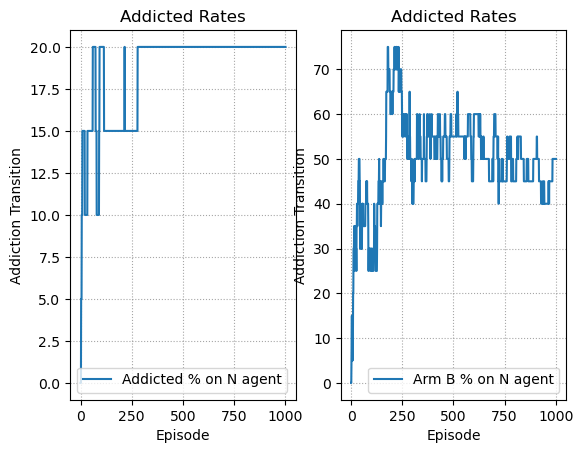

In [7]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(perc_agent, label='Addicted % on N agent')
plt.title('Addicted Rates')
plt.xlabel('Episode')
plt.ylabel('Addiction Transition')
plt.legend()
plt.grid(True, linestyle=':', color='gray', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(perc_recom, label='Arm B % on N agent')
plt.title('Addicted Rates')
plt.xlabel('Episode')
plt.ylabel('Addiction Transition')
plt.legend()
plt.grid(True, linestyle=':', color='gray', alpha=0.7)

# plt.subplot(2, 2, 3)
# plt.plot(mean_rewarda_recom, label='mean_rewarda_recom')
# plt.title('Addicted Rates')
# plt.xlabel('Episode')
# plt.ylabel('Addiction Transition')
# plt.legend()
# # plt.axvline(x=50, color='pink')  # Add red line at x=50
# plt.grid(True, linestyle=':', color='gray', alpha=0.7)
# plt.subplot(2, 2, 4)
# plt.plot(mean_rewardb_recom, label='mean_rewardb_recom')
# plt.title('Addicted Rates')
# plt.xlabel('Episode')
# plt.ylabel('Addiction Transition')
# plt.legend()
# plt.axvline(x=50, color='pink')  # Add red line at x=50


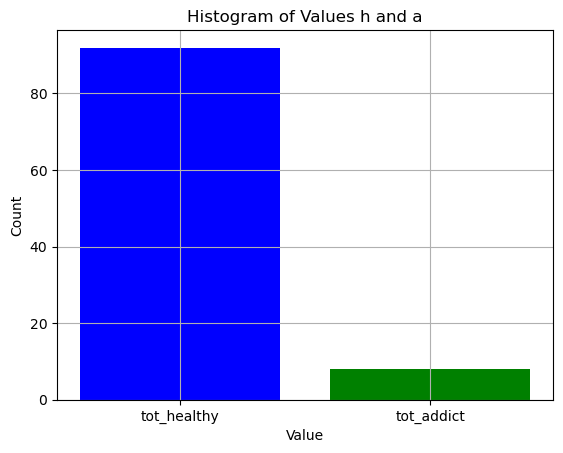

NameError: name 'recommender_h' is not defined

In [8]:
# plt.figure()

# plt.bar(['tot_healthy', 'tot_addict'], [tot_healthy, tot_addict], color=['blue', 'green'])
# plt.xlabel('Value')
# plt.ylabel('Count')
# plt.title('Histogram of Values h and a')
# plt.grid(True)
# plt.show()


# plt.bar(['recommender_healthy', 'recommender_addicted'], [recommender_h, recommender_a], color=['blue', 'green'])
# plt.xlabel('Value')
# plt.ylabel('Count')
# plt.title('Histogram of Values h and a')
# plt.grid(True)
# plt.show()

In [ ]:
# agenti
agents = []
addiction_states = []
rewards = [-2, -1, 1, 2]


# parametri
lr = 0.01


nagenti = 100


pbar_a = tqdm_notebook(total = nagenti * len(rewards), desc='Agent Loop')
timestamps = env.get_iter()+2

ie = 0.4
ed = ie / (timestamps / 2)  # reduce the exploration over time
fe = 0.1



addicted_agents = 0

tot_addict = 0
tot_healthy = 0

recommender_rew_b = 0

mean_addictive_agent = np.zeros([nagenti, timestamps])
mean_arms_t = np.zeros([nagenti, timestamps])
# mean_rewardb_recom = np.zeros(timestamps)
# mean_rewarda_recom = np.zeros(timestamps)


for r in rewards:
    env.set_reward(r)

    agents = []
    for _ in range(nagenti):
        # agent = MXLearningAgent(
        #     lr = lr,
        #     ie = ie,
        #     ed = ed,
        #     fe = fe,
        #     Beta = beta,
        #     Epsilon = 0.1,
        #     MBUS = 1,
        # )
        agent = MFLearningAgent(
            learning_rate = lr,
            initial_epsilon = ie,
            epsilon_decay = ed,
            final_epsilon = fe,
        )
        agents.append(agent)
    
    mean_addictive_agent = np.zeros([nagenti, timestamps])
    mean_arms_t = np.zeros([nagenti, timestamps])
    # mean_rewardb_recom = np.zeros(timestamps)
    # mean_rewarda_recom = np.zeros(timestamps)
    
    n_a = 0
    for agent in agents:
    
    
        pbar_a.update(1)
        obs, info = env.reset()

        
    
        done = False
    
        addicted_count = 0
        healthy_count = 0
        ad_count = 0
    
        n_t = 0
        while not done:
            
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
    
            agent.update(obs, action, reward, terminated, next_obs)
    
            #conto stati
            if(obs==3 and action == 4):
                ad_count += 1
            if(obs == 3 and next_obs == 4):
                addicted_count +=  1
            if(obs == 2 and next_obs == 1):
                healthy_count += 1
    
    
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
    
            # rewards_reco = env.get_rewards()
            # mean_rewardb_recom[n_t] += rewards_reco[1]
            # mean_rewarda_recom[n_t] += rewards_reco[0]
    
            if addicted_count > healthy_count:
                mean_addictive_agent[n_a][n_t] = 1
                #print("ad")
            else:
                mean_addictive_agent[n_a][n_t] = 0


            n_t += 1
    
        # arms = env.unwrapped.get_statistics()
            mean_arms_t[n_a][n_t] = env.unwrapped.get_arms()
    
        n_a += 1
        if addicted_count > healthy_count:
            tot_addict += 1

    print(r)
    perc_agent = []
    perc_recom = []
    for t in range(timestamps):
        s = 0
        s1 = 0
        for a in range(nagenti):
            s1 += mean_arms_t[a][t]
            s += mean_addictive_agent[a][t]
        perc_agent.append((s / nagenti) * 100)
        perc_recom.append((s1 / nagenti) * 100)
    #print(perc_agent)

    plt.figure(figsize=(16, 12))
    plt.subplot(2, 2, 1)
    plt.plot(perc_agent, label=f"addicted choice avg {nagenti} agent")
    plt.title(f"Addicted Rates with r = {r}")
    plt.xlabel('Episode')
    plt.ylabel('Addiction Transition')
    plt.legend()
    # plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)

    plt.subplot(2, 2, 2)
    plt.plot(perc_recom, label='Arm B % on N agent')
    plt.title('Addicted Rates')
    plt.xlabel('Episode')
    plt.ylabel('Addiction Transition')
    plt.legend()
    
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)


        
    
pbar_a.close()

/tmp/ipykernel_25250/260604005.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar_a = tqdm_notebook(total = nagenti * len(rewards), desc='Agent Loop')


Agent Loop:   0%|          | 0/400 [00:00<?, ?it/s]

/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_reward` for environment variables or `env.get_wrapper_attr('set_reward')` that will search the reminding wrappers.
  logger.warn(


-2
-1


## Beta variabile

In [ ]:
# agenti
agents = []
addiction_states = []

# parametri
lr = 0.05
n_episodes = 1

nagenti = 50

addicted_perc = []
beta_range = [0, 0.25, 0.5, 0.75, 1]


# pbar_b = tqdm(total = 5, position=0,  desc='Beta Loop')
pbar_a = tqdm_notebook(total = nagenti, desc='Agent Loop')
# pbar_i = tqdm(total = env.get_iter()+1, desc='Episode Loop', position = 2)

for B in beta_range:
    pbar_a.reset()
    
    ie = 0.4
    ed = ie / (env.get_iter() / 2)  # reduce the exploration over time
    fe = 0.1
    
    agents = []
    for _ in range(nagenti):
        agent = MXLearningAgent(
            lr = lr,
            ie = ie,
            ed = ed,
            fe = fe,
            Beta = B,
            Epsilon = 0.1,
            MBUS = 1,
        )
        agents.append(agent)
    

    addicted_agents = 0
    
    
    for agent in agents: 
        
        pbar_a.update(1) 
        obs, info = env.reset()
        
        done = False
        addicted_count = 0
        healthy = 0
        # play one episode
        
        # pbar_i.reset()
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            agent.update(obs, action, reward, terminated, next_obs)
            #conto stati
            if(obs == 3 and next_obs == 4):
                addicted_count +=  1
            if(obs == 2 and next_obs == 1):
                healthy += 1
            
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            # pbar_i.update(1)
            
        if addicted_count > healthy:
            addicted_agents += 1
  
    print(f"{B} {addicted_agents}")
    addicted_perc.append((addicted_agents / nagenti) * 100)
    # pbar_b.update(1)
    
pbar_a.close()
# pbar_b.close()
# pbar_i.close()

In [ ]:
timestamps = np.arange(len(beta_range))

# Print addicted percentage for debugging
print(addicted_perc)

# Plot the graph
plt.figure(figsize=(16, 6))
plt.errorbar(timestamps, addicted_perc, fmt='o', capsize=5, label='Addicted')
plt.xticks(timestamps, beta_range)  # Set beta values as x-axis ticks
plt.title('Addiction Rewards (testing)')
plt.xlabel('Beta Value')
plt.ylabel('Total Addicted')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()